In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import os
import struct
import numpy as np




In [3]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable

In [4]:

def load_mnist(path, kind='train'):
    """Load MNIST data from `path`"""
    labels_path = os.path.join(path,
                               '%s-labels-idx1-ubyte'
                               % kind)
    images_path = os.path.join(path,
                               '%s-images-idx3-ubyte'
                               % kind)
    with open(labels_path, 'rb') as lbpath:
        magic, n = struct.unpack('>II',
                                 lbpath.read(8))
        labels = np.fromfile(lbpath,
                             dtype=np.uint8)

    with open(images_path, 'rb') as imgpath:
        magic, num, rows, cols = struct.unpack('>IIII',
                                               imgpath.read(16))
        images = np.fromfile(imgpath,
                             dtype=np.uint8).reshape((len(labels),28,28))

    return images, labels

In [14]:
X_train, y_train = load_mnist('./data')
                              
X_test, y_test = load_mnist('./data',kind='t10k')
print(X_test.shape,y_test.shape)

(10000, 28, 28) (10000,)


In [15]:
def img_show(img):
    plt.figure(figsize=(1,1))
    plt.imshow(img,cmap='Greys',interpolation='nearest')
    

In [16]:
def imgs_show(imgs,row,col):
    fig,ax = plt.subplots(nrows=row,ncols=col,sharex=True,sharey=True)
    ax = ax.flatten()
    for i in range(row*col):
        img = imgs[i]
        ax[i].imshow(img,cmap='Greys', interpolation='nearest')
    
    ax[0].set_xticks([])
    ax[0].set_yticks([])
    plt.tight_layout()
    plt.show()
    
    

In [17]:
#shuf data
shuf_index = np.random.permutation(len(X_train))
train_x = X_train[shuf_index]
train_y = y_train[shuf_index]
print(y_train[:100])
print(train_y[:100])

[5 0 4 1 9 2 1 3 1 4 3 5 3 6 1 7 2 8 6 9 4 0 9 1 1 2 4 3 2 7 3 8 6 9 0 5 6
 0 7 6 1 8 7 9 3 9 8 5 9 3 3 0 7 4 9 8 0 9 4 1 4 4 6 0 4 5 6 1 0 0 1 7 1 6
 3 0 2 1 1 7 9 0 2 6 7 8 3 9 0 4 6 7 4 6 8 0 7 8 3 1]
[7 9 4 2 6 3 6 4 0 6 2 1 0 5 5 8 6 3 1 0 3 5 9 4 2 4 0 6 9 9 5 7 7 5 1 4 0
 7 5 4 4 3 3 0 7 6 1 7 4 6 3 9 2 3 8 5 7 4 1 7 4 2 7 3 8 9 3 0 5 4 0 0 3 5
 3 2 4 2 6 7 9 6 9 7 3 1 2 6 9 2 9 8 1 8 8 2 3 8 4 6]


In [18]:
def normal_minist(img):
    return (img / 255) -0.5

In [19]:
def expend_HWC(img):
    return np.expand_dims(img,axis=3)


In [20]:
def to_CHW(img):
    return np.transpose(img,(0,3,1,2))
def to_HWC(img):
    return np.transpose(img,(0,2,3,1))

In [21]:
train_real = expend_HWC(train_x)
train_real = normal_minist(train_real)
print(train_real.shape)
train_real = to_CHW(train_real)
print(train_real.shape)


test_real = expend_HWC(X_test)
test_real = normal_minist(test_real)
print(test_real.shape)
test_real = to_CHW(test_real)
print(test_real.shape)



(60000, 28, 28, 1)
(60000, 1, 28, 28)
(10000, 28, 28, 1)
(10000, 1, 28, 28)


[[[-0.5        -0.5        -0.5        -0.5        -0.5
   -0.5        -0.5        -0.5        -0.5        -0.5
   -0.5        -0.5        -0.5        -0.5        -0.5
   -0.5        -0.5        -0.5        -0.5        -0.5
   -0.5        -0.5        -0.5        -0.5        -0.5
   -0.5        -0.5        -0.5       ]
  [-0.5        -0.5        -0.5        -0.5        -0.5
   -0.5        -0.5        -0.5        -0.5        -0.5
   -0.5        -0.5        -0.5        -0.5        -0.5
   -0.5        -0.5        -0.5        -0.5        -0.5
   -0.5        -0.5        -0.5        -0.5        -0.5
   -0.5        -0.5        -0.5       ]
  [-0.5        -0.5        -0.5        -0.5        -0.5
   -0.5        -0.5        -0.5        -0.5        -0.5
   -0.5        -0.5        -0.5        -0.5        -0.5
   -0.5        -0.5        -0.5        -0.5        -0.5
   -0.5        -0.5        -0.5        -0.5        -0.5
   -0.5        -0.5        -0.5       ]
  [-0.5        -0.5        -0.5        -

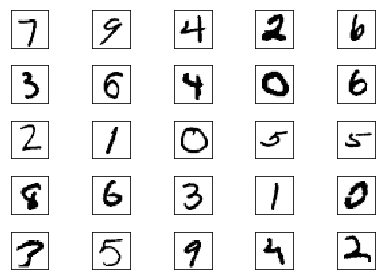

[7 9 4 2 6 3 6 4 0 6 2 1 0 5 5 8 6 3 1 0 3 5 9 4 2]


In [26]:
print(train_real[0])
imgs_show(np.squeeze (train_real[0:25]),5,5)
print(train_y[0:25])

In [27]:
def num_flat_features(x):
    size = x.size()[1:]
    num_features =1
        
    for s in size:
        num_features *= s
    return num_features
        

In [28]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5,stride=2)
        self.conv2 = nn.Conv2d(10, 10, kernel_size=3,stride=2)
        self.conv3 = nn.Conv2d(10,20,kernel_size=5,stride=2)
        self.conv4 = nn.Conv2d(20,20,kernel_size=3,stride=2)
        
        self.conv3_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)
        self.features={}


    def forward(self, x):
        
        x = F.relu(self.conv1(x))
        self.features['relu1'] = x
#         x = F.leaky_relu(self.conv2(x))
#         self.features['relu2'] = x
        x = self.conv3(x)
        self.features['conv3'] = x
        x = F.relu( x)
        self.features['relu3'] = x
#         x = self.conv3_drop(x)
#         x = F.leaky_relu(self.conv4(x))
#         self.features['relu4'] = x
        
        x = x.view(-1, num_flat_features(x))
        self.features['flat'] = x
        x = F.relu(self.fc1(x))
        self.features['fc1'] = x
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        self.features['fc2'] = x
        return F.log_softmax(x, dim=1)
    


In [29]:
def getnext(train_x,train_y,batch_size):
    batchs = len(train_y) // batch_size
    print(len(train_y),batchs)

    for i in range(batchs):
        x = train_x[batch_size * i : batch_size * (i+1)]
        y = train_y[batch_size * i : batch_size * (i+1)]
        yield x,y
        

In [30]:
datas = getnext(train_real,train_y,20000)

for x,y in datas:
    print(x.shape)
    print(y.shape)


60000 3
(20000, 1, 28, 28)
(20000,)
(20000, 1, 28, 28)
(20000,)
(20000, 1, 28, 28)
(20000,)


In [31]:
use_cuda = torch.cuda.is_available()
torch.manual_seed(666)
device = torch.device("cuda" if use_cuda else "cpu")
net = Net().to(device)
net.double()

optimizer = optim.SGD(net.parameters(),lr=0.003,momentum=0.9,weight_decay=1e-4)


In [35]:
net.train()
for epoch in range(25):
    datas = getnext(train_real,train_y,64)
    trainloss = 0
    
    for x,y in datas:
        inputs, labels = Variable(torch.from_numpy(x)).to(device), Variable(torch.from_numpy(y).long()).to(device)
#         print(labels)
        optimizer.zero_grad()
        output = net(inputs)
#         print(output.size())
        loss = F.nll_loss(output,labels)
        trainloss += loss.item()
        loss.backward()
        optimizer.step()
        
    print('%d  loss: %.3f' % (epoch ,  trainloss))
torch.save(net,'model.pkl')

60000 937
0  loss: 146.466
60000 937
1  loss: 133.788
60000 937
2  loss: 127.412
60000 937
3  loss: 119.625
60000 937
4  loss: 114.651
60000 937
5  loss: 107.425
60000 937
6  loss: 102.863
60000 937
7  loss: 98.696
60000 937
8  loss: 95.393
60000 937
9  loss: 92.912
60000 937
10  loss: 90.005
60000 937
11  loss: 84.104
60000 937
12  loss: 82.855
60000 937
13  loss: 82.005
60000 937
14  loss: 79.398
60000 937
15  loss: 75.022
60000 937
16  loss: 72.241
60000 937
17  loss: 74.129
60000 937
18  loss: 70.172
60000 937
19  loss: 67.913
60000 937
20  loss: 67.320
60000 937
21  loss: 67.783
60000 937
22  loss: 62.848
60000 937
23  loss: 63.587
60000 937
24  loss: 61.452


C:\Program Files\Anaconda3\lib\site-packages\torch\serialization.py:193: UserWarning: Couldn't retrieve source code for container of type Net. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [42]:
net = torch.load('model.pkl')
net.to(device)
net.eval()
test_loss = 0
correct = 0

with torch.no_grad():
    test_datas = getnext(test_real,y_test,32)
    for x ,y in test_datas:
        inputs, labels = Variable(torch.from_numpy(x)).to(device), Variable(torch.from_numpy(y).long()).to(device)
        output = net(inputs)
        test_loss += F.nll_loss(output, labels, size_average=False).item() # sum up batch loss
        pred = output.max(1,keepdim=True)[1]
#         print(pred)
        correct += pred.eq(labels.view_as(pred)).sum().item()
#         print(correct)
        
print('\nTest set: Average loss: {:.4f}, Accuracy: {} ({:.4f}%)\n'.format(
        test_loss, correct,100. * correct / 10000))
        
        
        

10000 312

Test set: Average loss: 442.0851, Accuracy: 9854 (98.5400%)



tensor([[ 0]])
(20, 4, 4)
torch.Size([10, 1, 5, 5])


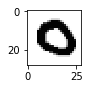

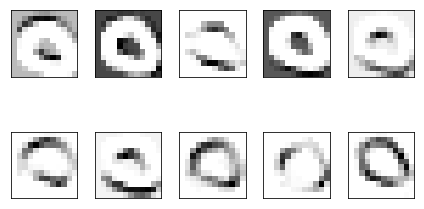

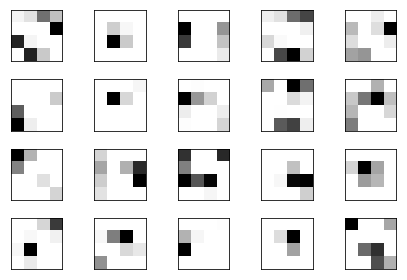

In [41]:
net.eval()
with torch.no_grad():
    x ,y = train_real[8:9],train_y[8:9]
    inputs, labels = Variable(torch.from_numpy(x)).to(device), Variable(torch.from_numpy(y).long()).to(device)
    output = net(inputs)
    pred = output.max(1,keepdim=True)[1]
    print(pred)
    imgs_relu1 = np.squeeze(net.features['relu1'].cpu().numpy())
    imgs_relu3 = np.squeeze(net.features['relu3'].cpu().numpy())
#     print(x.shape)
    
    print(imgs_relu3.shape)
#     print(net.features['relu2'].size())
#     print(net.features['relu3'].size())
#     print(net.features['relu4'].size())
#     print(net.features['flat'].size())
#     print(imgs_relu1[9])
    print(net.conv1.weight.size())
    img_show(np.squeeze(x))
    imgs_show( imgs_relu1,2,5)
    imgs_show( imgs_relu3,4,5)
#     imgs_show(np.squeeze(net.conv1.weight),2,5)
#     imgs_show(np.squeeze(net.conv2.weight),2,5)
    